In [1]:
import numpy as np
from scipy import signal
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import pyxdf
import glob
import os
from pyedflib import highlevel
import config
from utils.freq_calculator import do_bandpass
from utils.edf_convert import edf_info_single_channel

### Initialise constants

In [2]:
folder = "01_Pre_study"
subject = "S007"
night = "night2"
idun_file_ending = "synced_data"

freq = [0.3, 45]
channels_to_filter = ["IDUN"]
upscale_factor = 1
channels_to_upscale = [
    "AUDIO",
    "POSITION",
    "CHIN",
    "LEFT_EEG",
    "LEFT_EYE",
    "RIGHT_EYE",
    "RIGHT_EEG",
    "MASTOID",
]
channels_to_remove = []
voltage_units = [
    "",
    "uV",
    "uV",
    "uV",
    "uV",
    "",
    "uV",
    "uV",
    "uV",
]  # AUDIO and POSITION would need no unit
clip_limits = [-500, 500]
patient_additional = "IDUN Technologies"
rec_type = "Sleep recording"

csv_file_path = glob.glob(
    os.path.join(folder, subject, night, f"*{idun_file_ending}.csv")
)[0]

### Upload data

The synced data output from the sync_main stores the data as a dataframe

In [3]:
# load complete data set
data_all = pd.read_csv(csv_file_path, index_col=0)

data_all.head()

,AUDIO,CHIN,LEFT_EEG,LEFT_EYE,MASTOID,POSITION,RIGHT_EEG,RIGHT_EYE,IDUN
0.000,7.849863,-1.150347,-27.236978,3.227136,30.503151,7.002667,1.116844,-12.547017,17.857770
0.004,7.865978,-8.427137,-26.350444,0.113559,26.975967,7.002692,-3.102237,-14.739494,13.667788
0.008,7.616174,-8.502008,-24.489598,-4.079216,24.894765,7.002716,-5.964428,-15.235406,8.183231
0.012,7.088725,-1.720811,-21.829495,-7.135601,26.225555,7.002740,-5.756810,-13.650226,-1.971026
0.016,6.324792,4.808293,-20.063536,-9.272938,31.266788,7.002764,-5.168275,-12.539544,-7.384913


### Remove data

Some channels may not make sense for the edf analysis so it is best to remove them

In [ ]:
pruned_data = data_all.drop(columns=channels_to_remove)

### Filter data

It is important to filter data because EDF only has 16 bits to represent the signal. If we don't filter the data, the signal will be distorted. This is because if there is a DC shift of the signal, the EDF converter is forced to reduce the resolution of the signal to represent the DC shift.

In [ ]:
preprocessed_data = pruned_data.copy()
for channel in channels_to_filter:
    raw_eeg = np.array(data_all[channel].values)
    filtered_eeg = do_bandpass(raw_eeg, freq, sample_rate=config.BASE_SAMPLE_RATE)
    preprocessed_data[channel] = filtered_eeg

preprocessed_data.head()

,AUDIO,CHIN,LEFT_EEG,LEFT_EYE,MASTOID,POSITION,RIGHT_EEG,RIGHT_EYE,IDUN
0.000,2.678350,-2.062166,-0.318644,-1.127049,0.702094,7.000000,-0.543016,0.259682,11.795794
0.004,13.064953,-22.354915,-4.189354,-2.484423,2.504043,7.019316,-4.582313,-1.062871,16.918166
0.008,25.898951,-124.857424,-33.835557,-14.867236,69.020805,7.038448,-34.629211,-12.560248,22.023087
0.012,38.917066,-387.284992,-174.796645,-76.868435,374.017735,7.057393,-176.549703,-68.483973,24.102225
0.016,49.757426,-808.817196,-656.043205,-290.864429,1380.774015,7.076153,-660.279391,-260.007434,22.656348


### Scale data

Some of the data may not be in the same scale, such as in this example the external dataset is in volts while the idun data is in microvolts. We need to scale the data to the same scale.

In [ ]:
scaled_preprocessed_data = preprocessed_data.copy()
for channel in channels_to_upscale:
    scaled_preprocessed_data[channel] = preprocessed_data[channel] * upscale_factor

scaled_preprocessed_data.head()

,AUDIO,CHIN,LEFT_EEG,LEFT_EYE,MASTOID,POSITION,RIGHT_EEG,RIGHT_EYE,IDUN
0.000,2.678350,-2.062166,-0.318644,-1.127049,0.702094,7.000000,-0.543016,0.259682,11.795794
0.004,13.064953,-22.354915,-4.189354,-2.484423,2.504043,7.019316,-4.582313,-1.062871,16.918166
0.008,25.898951,-124.857424,-33.835557,-14.867236,69.020805,7.038448,-34.629211,-12.560248,22.023087
0.012,38.917066,-387.284992,-174.796645,-76.868435,374.017735,7.057393,-176.549703,-68.483973,24.102225
0.016,49.757426,-808.817196,-656.043205,-290.864429,1380.774015,7.076153,-660.279391,-260.007434,22.656348


### Removed too high spikes

The EDF converter cannot handle too high spikes. We need to remove them. Therefore any data above 1000 microvolts is made equal to 1000 microvolts. The same with the negative values.

In [7]:
# clip data
clipped_data = scaled_preprocessed_data.copy()
all_channels = list(clipped_data.columns)
for channel in all_channels:
    clipped_data[channel] = clipped_data[channel].clip(
        lower=clip_limits[0], upper=clip_limits[1]
    )

### Visualise data

This is for sanity check. We can see if the data is in the correct scale and if the data is filtered correctly.

Notice how I re-reference the data so that it shows similar signals as IDUN

Text(0.5, 0, 'Time (s)')

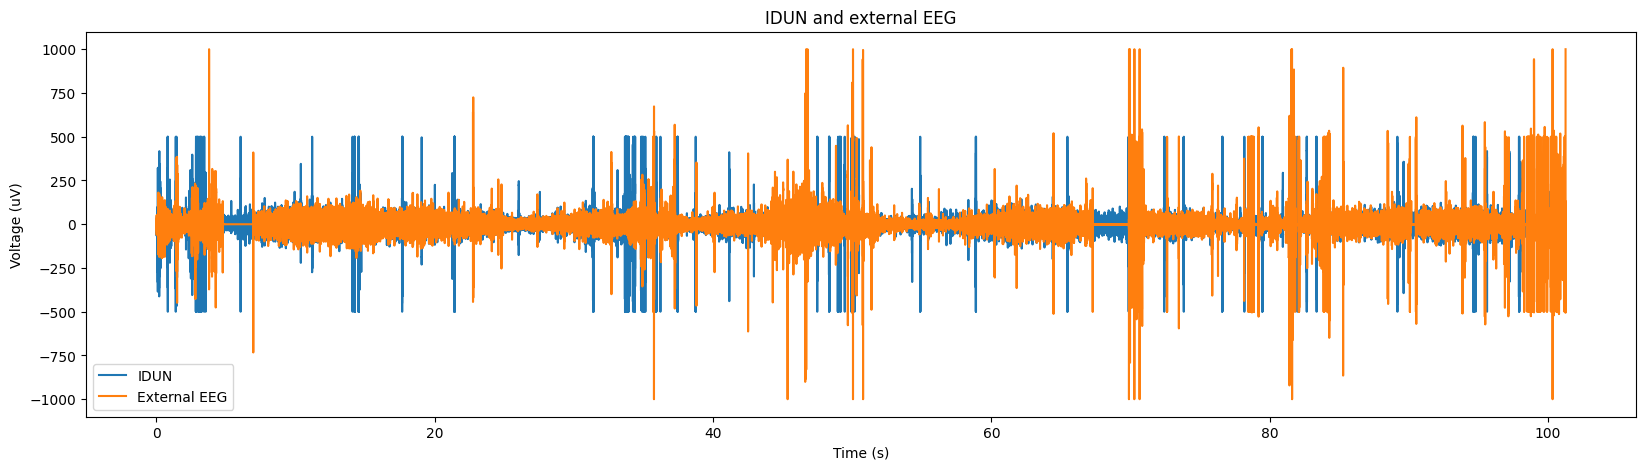

In [8]:
# plot LEFT_EEG, RIGHT_EEG, IDUN
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
time_axis_index = clipped_data.index.values / config.BASE_SAMPLE_RATE
ax.plot(time_axis_index, clipped_data["IDUN"].values, label="IDUN")
ax.plot(
    time_axis_index,
    clipped_data["RIGHT_EEG"].values - clipped_data["LEFT_EEG"].values,
    label="External EEG",
)
plt.title("IDUN and external EEG")
plt.legend()
plt.ylabel("Voltage (uV)")
plt.xlabel("Time (s)")
# plt.ylim(-600, 600)

### Do EDF conversion

In [9]:
# Get Channel names
ch_names = list(clipped_data.columns)
print(ch_names)

# Transpose data
clipped_data_values = clipped_data.values
clipped_data_tr = np.transpose(clipped_data_values)
print(np.shape(clipped_data_tr))

# Create saving name
new_savename = os.path.join(folder, subject, night, "eeg_data.edf")

# prepare edf info
signal_info = []
for chan_indx in range(len(ch_names)):
    add_channel = edf_info_single_channel(
        clipped_data_tr[chan_indx],
        ch_names[chan_indx],
        config.BASE_SAMPLE_RATE,
        voltage_units[chan_indx],
    )
    signal_info.append(add_channel)

# create header for edf conversioon
data_header = highlevel.make_header(
    patientname=subject,
    patient_additional=patient_additional,
    recording_additional=rec_type,
)
# save signal as edf
highlevel.write_edf(new_savename, clipped_data_tr, signal_info, data_header)

['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION', 'RIGHT_EEG', 'RIGHT_EYE', 'IDUN']
(9, 6329059)


c:\Users\feder\Envs\labelling\lib\site-packages\pyedflib\edfwriter.py:91: UserWarning: Physical minimum for channel 5 (POSITION) is 0.9480277470909132, which has 18 chars, however, EDF+ can only save 8 chars, will be truncated to 0.948027, some loss of precision is to be expected
  warnings.warn('Physical minimum for channel {} ({}) is {}, which has {} chars, '\
c:\Users\feder\Envs\labelling\lib\site-packages\pyedflib\edfwriter.py:98: UserWarning: Physical minimum for channel 5 (POSITION) is 7.987999113590995, which has 17 chars, however, EDF+ can only save 8 chars, will be truncated to 7.987999, some loss of precision is to be expected.
  warnings.warn('Physical minimum for channel {} ({}) is {}, which has {} chars, '\


True